<a href="https://colab.research.google.com/github/BertrandCAS/bcamasteria/blob/main/TFM_Yolo_V11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MODELOS YOLO V11

Clonar el repositorio de YOLOv10 y instalar las librerias
Init y load de la librerias

In [ ]:
!git clone https://github.com/ultralytics/ultralytics.git
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ultralytics --upgrade


Cloning into 'ultralytics'...
remote: Enumerating objects: 48527, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 48527 (delta 214), reused 196 (delta 184), pack-reused 48283 (from 4)
Receiving objects: 100% (48527/48527), 40.47 MiB | 16.48 MiB/s, done.
Resolving deltas: 100% (35742/35742), done.
Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 49.0 MB/s eta 0:00:00


In [ ]:
import torch
print("GPU disponible :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nom du GPU :", torch.cuda.get_device_name(0))

GPU disponible : True
Nom du GPU : NVIDIA L4


# Función para crear el archivo YAML
Si ya existe un archivo `dataset.yaml` en tu configuración,
no necesita ejecutar esta función.

In [ ]:
import os
from google.colab import drive

def create_yaml(ruta_dataset, clases):
    """
    Crea el archivo YAML necesario para entrenar el modelo YOLO.
    Define las rutas de entrenamiento y validación, el número de clases y sus nombres.
    """
    contenido_yaml = f"""
    train: {os.path.join(ruta_dataset, 'train')}
    val: {os.path.join(ruta_dataset, 'valid')}

    nc: {len(clases)}  # Número de clases
    names: {clases}  # Lista de clases
    """
    ruta_yaml = os.path.join(ruta_dataset, 'dataset.yaml')
    with open(ruta_yaml, 'w') as archivo_yaml:
        archivo_yaml.write(contenido_yaml)
    print(f"✅ Archivo dataset.yaml creado en: {ruta_yaml}")
    return ruta_yaml
# Número de clases
drive.mount('/content/drive')

# Ruta al directorio que contiene el dataset (padre de train, valid, test)
dataset_path = '/content/drive/My Drive/TFM DATASET YOLO'

# Verifica si el directorio existe, si no, lo crea
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# Definir las clases
clases = ['Casco', 'Chaleco', 'No-Casco', 'No-Chaleco', 'Persona']

# Ruta al archivo YAML
ruta_yaml = os.path.join(dataset_path, 'dataset.yaml')

# Verificar si el archivo YAML existe, si no, crearlo
if not os.path.exists(ruta_yaml):
    print(f"Archivo {ruta_yaml} no encontrado. Creando el archivo...")
    ruta_yaml = create_yaml(dataset_path, clases)
else:
    print(f"✅ El archivo {ruta_yaml} ya existe. No es necesario crearlo nuevamente.")

Mounted at /content/drive
✅ El archivo /content/drive/My Drive/TFM DATASET YOLO/dataset.yaml ya existe. No es necesario crearlo nuevamente.


# Este codigo vericifca la existencia de las carpetas 'train' y 'valid'

In [ ]:

train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'valid')

if not os.path.exists(train_path):
    print(f"La carpeta 'train' no existe: {train_path}")
else:
    print(f"La carpeta 'train' contiene: {os.listdir(train_path)}")

if not os.path.exists(valid_path):
    print(f"La carpeta 'valid' no existe: {valid_path}")
else:
    print(f"La carpeta 'valid' contiene: {os.listdir(valid_path)}")

/content
La carpeta 'train' contiene: ['_darknet.labels', 'images', 'labels', 'labels.cache']
La carpeta 'valid' contiene: ['images', 'labels', 'labels.cache']


#Script de validación del dataset YOLO
Esta funcion permite que el script valide el dataset de imágenes y anotaciones, asegurándose de que las carpetas necesarias existan y que haya coherencia entre las imágenes y sus correspondientes anotaciones.

In [ ]:
import os

def validate_dataset(dataset_path):

    # Lista para almacenar los problemas detectados
    issues = []

    # Validar las subcarpetas 'train' y 'valid'
    for split in ['train', 'valid']:
        # Rutas a las carpetas de imágenes y anotaciones
        images_dir = os.path.join(dataset_path, split, 'images')
        labels_dir = os.path.join(dataset_path, split, 'labels')

        # Verificar si las carpetas existen
        if not os.path.exists(images_dir):
            issues.append(f"La carpeta de imágenes no existe: {images_dir}")
            continue  # Continuar con la siguiente carpeta
        if not os.path.exists(labels_dir):
            issues.append(f"La carpeta de anotaciones no existe: {labels_dir}")
            continue

        # Listar los archivos en las carpetas (solo extensiones válidas)
        images = {os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))}
        labels = {os.path.splitext(f)[0] for f in os.listdir(labels_dir) if f.lower().endswith('.txt')}

        # Detectar imágenes sin anotaciones y anotaciones sin imágenes
        missing_labels = images - labels  # Imágenes sin archivo .txt
        missing_images = labels - images  # Archivos .txt sin imagen

        # Agregar problemas encontrados a la lista de errores
        if missing_labels:
            issues.append(f"En '{split}': Faltan anotaciones para las imágenes: {', '.join(missing_labels)}")
        if missing_images:
            issues.append(f"En '{split}': Faltan imágenes para las anotaciones: {', '.join(missing_images)}")

    # Si se detectaron problemas, lanzar una excepción con detalles
    if issues:
        raise ValueError("\n".join(issues))

    # Si todo está correcto, mostrar mensaje de éxito
    print("Validación del dataset completada con éxito. No se detectaron problemas.")

# Ruta al dataset principal
dataset_path = "/content/drive/My Drive/TFM DATASET YOLO"

# Validar el dataset
try:
    validate_dataset(dataset_path)
except ValueError as e:
    print(f"Errores detectados durante la validación:\n{e}")

Validación del dataset completada con éxito. No se detectaron problemas.


# Entrenamiento de un modelo YOLO
Este código entrena un modelo YOLO utilizando un archivo de configuración YAML y un dataset predefinido. Una vez completado el entrenamiento, verifica la presencia de los archivos de peso best.pt y last.pt generados durante el proceso. Permite configurar parámetros clave como el número de épocas y el tamaño de las imágenes para ajustar el entrenamiento según sea necesario.

Se asegura de que el archivo YAML exista antes de comenzar y notifica sobre cualquier archivo de peso que falte al finalizar el entrenamiento.

In [ ]:
import os
from ultralytics import YOLO
from google.colab import files

# Funcion para entrenar un modelo YOLO
def entrenar_yolo(version, variante, ruta_yaml, epocas=30, tamano_img=640, tamano_batch=16):
    versiones_validas = ["8", "10", "11"]
    variantes_validas = ["n", "s", "m"]

    # Validar la version de YOLO en input
    if version not in versiones_validas:
        raise ValueError(f"Versión de YOLO no válida: {version}. Versiones soportadas: {versiones_validas}.")

    # Validar la variante de YOLO en input
    if variante not in variantes_validas:
        raise ValueError(f"Variante de YOLO no válida: {variante}. Variantes soportadas: {variantes_validas}.")

    # Definir el nombre del proyecto y de la ejecución
    nombre_proyecto = f"YOLOv{version}"  # Ejemplo: YOLOv8 o YOLOv10
    nombre_ejecucion = f"ejecucion_{variante}"

    archivo_pesos = f"yolov{version}{variante}.pt"  # Construir el nombre del archivo de pesos

    print(f"\n Cargando el modelo YOLOv{version}{variante} desde {archivo_pesos}")
    modelo = YOLO(archivo_pesos)

    # Inicio del entrenamiento
    print("\n=== Inicio del entrenamiento de YOLO ===")
    modelo.train(
        data=ruta_yaml,
        epochs=epocas,
        imgsz=tamano_img,
        batch=tamano_batch,
        lr0=0.005,            # Learning rate mas baja
        weight_decay=0.0005,  # Regularizacion
        momentum=0.9,         # Inercia
        optimizer='SGD',      # Probar Adam o SGD
        project=nombre_proyecto,
        name=nombre_ejecucion,
        save=True
    )

    # Capturar dinamicamente la ruta del directorio de resultados
    directorio_resultados = os.path.join(modelo.trainer.save_dir, "weights")
    print(f"\n Entrenamiento completado. Los resultados se han guardado en {directorio_resultados}.")

    # Descargar los archivos generados
    descargar_archivos_especificos(directorio_resultados)

# Función para descargar archivos específicos
def descargar_archivos_especificos(ruta_directorio):
    archivos_especificos = ["last.pt", "best.pt"]
    if os.path.exists(ruta_directorio):
        print(f" Directorio encontrado: {ruta_directorio}")
        for nombre_archivo in archivos_especificos:
            ruta_archivo = os.path.join(ruta_directorio, nombre_archivo)
            if os.path.exists(ruta_archivo):
                print(f"Descargando el archivo: {nombre_archivo}")
                files.download(ruta_archivo)  # Descargar cada archivo
            else:
                print(f" Archivo no encontrado: {ruta_archivo}")
    else:
        print(f" Directorio no encontrado: {ruta_directorio}")

# Boucle para configurar y entrenar el modelo
while True:
    try:
        print("\n=== Configuración del Modelo YOLO ===")
        version_input = input("Ingrese la versión de YOLO (8, 10, 11): ").strip()
        variante_input = input("Ingrese la variante (n para Nano, s para Small): ").strip().lower()
        # Se cambia la ruta para coresponder a su configuracion donde esta el fichero
        ruta_yaml = "/content/drive/My Drive/TFM DATASET YOLO/dataset.yaml"
        if not os.path.exists(ruta_yaml):
            raise FileNotFoundError(f"Archivo YAML no encontrado: {ruta_yaml}")

        # Se entrena el modelo con los parametros proporcionados
        entrenar_yolo(version=version_input, variante=variante_input, ruta_yaml=ruta_yaml)
        break  # Salir del bucle si todo es válido

    except ValueError as ve:
        print(ve)
        print("Por favor, inténtelo de nuevo con entradas válidas.")
    except FileNotFoundError as fe:
        print(fe)
        break  # Salir del bucle si no se encuentra un archivo esencial
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}")




Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

=== Configuration du Modèle YOLO ===
Entrez la version de YOLO (8, 10, 11) : 11
Entrez la variante (n pour Nano, s pour Small) : s

✅ Chargement du modèle YOLOv11s depuis yolov11s.pt
[Errno 2] No such file or directory: 'yolov11s.pt'



#Validación del Modelo YOLO V10
Este script permite la gestión de un flujo de trabajo relacionado con el entrenamiento y validación de modelos YOLO. Incluye funciones para subir archivos de pesos desde el sistema local a un directorio en Colab, buscar el archivo más relevante (best.pt) y cargar el modelo YOLO para realizar la validación utilizando un archivo YAML del conjunto de datos. También verifica métricas clave como precisión, recall y mAP para evaluar el rendimiento del modelo
---



In [ ]:
# Part 1: Gestión de imports y funciones comunes
# ==============================================

# Importamos las bibliotecas necesarias
import os
from ultralytics import YOLO  # Para cargar y validar el modelo YOLO
from google.colab import files  # Para subir archivos desde el sistema local

# Función para crear un directorio si no existe
def create_directory(directory_path):
    os.makedirs(directory_path, exist_ok=True)
    print(f"Directorio verificado/creado: {directory_path}")

# Función para subir archivos de pesos
def upload_weights(uploaded_weights_dir='./uploaded_weights'):
    """
    Permite al usuario subir archivos desde su computadora y los guarda en un directorio específico.
    """
    create_directory(uploaded_weights_dir)
    print("\n=== Subir archivos de pesos ===")
    uploaded_files = files.upload()  # Subimos los archivos desde el sistema local
    for file_name in uploaded_files.keys():
        file_path = os.path.join(uploaded_weights_dir, file_name)
        with open(file_path, 'wb') as f:  # Guardamos los archivos en el directorio destino
            f.write(uploaded_files[file_name])
        print(f"Archivo {file_name} guardado en: {file_path}")
    return uploaded_weights_dir

# Función para seleccionar un archivo en la lista
def select_file_from_list(uploaded_weights_dir='./uploaded_weights'):
    """
    Permite al usuario seleccionar un archivo en la lista de archivos disponibles.
    """
    files = os.listdir(uploaded_weights_dir)
    if not files:
        raise FileNotFoundError(f"No hay archivos en el directorio: {uploaded_weights_dir}")

    print("\nArchivos disponibles:")
    for idx, file_name in enumerate(files, 1):
        print(f"{idx}. {file_name}")

    while True:
        try:
            choice = int(input("\nSeleccione un archivo ingresando su número: ").strip())
            if 1 <= choice <= len(files):
                selected_file = files[choice - 1]
                print(f"Archivo seleccionado: {selected_file}")
                return selected_file
            else:
                print("Número inválido. Intente nuevamente.")
        except ValueError:
            print("Entrada inválida. Ingrese un número válido.")

# Función para cargar un modelo YOLO
def load_model(weight_path):
    """
    Carga un modelo YOLO desde un archivo de pesos.
    """
    if not os.path.exists(weight_path):
        raise FileNotFoundError(f"❌ Archivo no encontrado: {weight_path}")
    print(f"Cargando modelo desde: {weight_path}")
    return YOLO(weight_path)

# Función para imprimir detalles del modelo
def print_model_details(model):
    """
    Imprime la estructura del modelo y el número total de parámetros.
    """
    print("\n=== Detalles del modelo ===")
    print(model)  # Imprime la estructura del modelo
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Número total de parámetros: {total_params}")

# Función para calcular FPS
def calculate_fps(results):
    """
    Calcula los FPS (Frames per Second) basado en el tiempo de inferencia promedio por imagen.
    """
    avg_inference_time = results.speed['inference']  # Tiempo promedio de inferencia (ms)
    fps = 1000 / avg_inference_time  # Convertir de ms a FPS
    print("\n=== Métricas de rendimiento ===")
    print(f"Tiempo de inferencia promedio por imagen: {avg_inference_time:.2f} ms")
    print(f"FPS estimados: {fps:.2f} imágenes/segundo")
    return fps

# Part 2: Ejecución del flujo principal
# ================================================

# Directorio para subir archivos de pesos
uploaded_weights_dir = upload_weights()

# Verificar los archivos en el directorio
print("Contenido del directorio de archivos subidos:")
print(os.listdir(uploaded_weights_dir))

try:
    # Seleccionar un archivo de pesos de la lista
    selected_weight_name = select_file_from_list(uploaded_weights_dir)

    # Cargar el modelo desde el archivo seleccionado
    best_weight_path = os.path.join(uploaded_weights_dir, selected_weight_name)
    model = load_model(best_weight_path)

    # Imprimir los detalles del modelo
    print_model_details(model)

    # Ruta del archivo YAML del conjunto de datos
    yaml_file_path = '/content/drive/My Drive/TFM DATASET YOLO/dataset.yaml'
    if not os.path.exists(yaml_file_path):
        raise FileNotFoundError(f"❌ Archivo YAML no encontrado: {yaml_file_path}")
    print(f"Archivo YAML encontrado: {yaml_file_path}")

    # Validar el modelo
    print("\n=== Iniciando la validación del modelo ===")
    results = model.val(
        data=yaml_file_path,
        imgsz=640,
        save=True
    )

    # Mostrar métricas de validación
    print("\n=== Resultados de la validación ===")
    print(f"Precisión (P): {results.box.mp:.2f}")
    print(f"Recall (R): {results.box.mr:.2f}")
    print(f"mAP@50: {results.box.map50:.2f}")
    print(f"mAP@50-95: {results.box.map:.2f}")

    # Calcular y mostrar FPS
    calculate_fps(results)

except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")


✅ Directorio verificado/creado: ./uploaded_weights

=== Subir archivos de pesos ===


Saving bestv8n.pt to bestv8n (3).pt
✅ Archivo bestv8n (3).pt guardado en: ./uploaded_weights/bestv8n (3).pt
📂 Contenido del directorio de archivos subidos:
['bestv8n (3).pt', 'bestv8n (2).pt']

📂 Archivos disponibles:
1. bestv8n (3).pt
2. bestv8n (2).pt

Seleccione un archivo ingresando su número: 1
✅ Archivo seleccionado: bestv8n (3).pt
✅ Cargando modelo desde: ./uploaded_weights/bestv8n (3).pt

=== Detalles del modelo ===
YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
   

val: Scanning /content/drive/My Drive/TFM DATASET YOLO/valid/labels.cache... 555 images, 31 backgrounds, 0 corrupt: 100%|██████████| 555/555 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:46<00:00,  1.32s/it]


                   all        555       4651      0.832       0.66      0.733      0.468
                 Casco        275        712      0.885      0.643      0.704      0.432
               Chaleco        276        718       0.81      0.647       0.72      0.447
              No-Casco        272        465      0.823      0.615      0.698      0.413
            No-Chaleco        378        784      0.803      0.672      0.744      0.473
               Persona        523       1972      0.839      0.725      0.801      0.576
Speed: 0.9ms preprocess, 1.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val4

=== Resultados de la validación ===
📊 Precisión (P): 0.83
📊 Recall (R): 0.66
📊 mAP@50: 0.73
📊 mAP@50-95: 0.47

=== Métricas de rendimiento ===
⏱️ Tiempo de inferencia promedio por imagen: 1.91 ms
🚀 FPS estimados: 523.26 imágenes/segundo


# Análisis Detallado de Métricas YOLO por Clase
Este bloque analiza las métricas de validación YOLO por clase, incluyendo precisión, recall, mAP@50 y mAP@50-95. Evalúa el rendimiento de cada clase y proporciona una interpretación basada en los valores de las métricas, identificando si el modelo necesita ajustes o si tiene un buen desempeño. Es una herramienta útil para identificar fortalezas y debilidades en el rendimiento del modelo por categoría.

Precisión (P): Indica qué tan exacto es el modelo al detectar objetos, mostrando la proporción de detecciones correctas sobre el total de predicciones realizadas.

Recall (R): Mide la capacidad del modelo para encontrar todos los objetos relevantes en las imágenes.

mAP@50: Representa la precisión promedio del modelo usando un umbral de coincidencia (IoU) del 50%.

mAP@50-95: Evalúa la precisión promedio en un rango de umbrales (50% a 95%), proporcionando una evaluación más completa del rendimiento.

In [ ]:
# Bloque para analizar las métricas YOLO por clase
def analyze_class_metrics(results):
    """
    Analiza las métricas de validación YOLO para cada clase y muestra el estado por clase.
    """
    print("\n=== Análisis de métricas por clase ===\n")

    # Acceder a los nombres de las clases y métricas
    for i, class_name in results.names.items():
        # Obtener las métricas por clase
        class_metrics = results.box.class_result(i)  # Devuelve [precision, recall, ap50, ap50-95]
        precision = class_metrics[0]
        recall = class_metrics[1]
        map50 = class_metrics[2]
        map50_95 = class_metrics[3]

        # Mostrar las métricas por clase
        print(f"=== Clase: {class_name} ===")
        print(f"Precisión (P): {precision:.2f}")
        print(f"Recall (R): {recall:.2f}")
        print(f"mAP@50: {map50:.2f}")
        print(f"mAP@50-95: {map50_95:.2f}")

        # Estado basado en las métricas
        print("\n=== Estado de la clase ===")
        if precision > 0.8 and recall > 0.6:
            print("Buen rendimiento: Alta precisión y recall aceptable.")
        elif precision > 0.8:
            print("Alta precisión, pero bajo recall.")
        elif recall > 0.6:
            print("Recall aceptable, pero precisión baja.")
        else:
            print("Rendimiento insuficiente: Se necesitan ajustes.")
        print("\n" + "="*30 + "\n")


def calculate_fps(results):
    """
    Calcula los FPS (Frames per Second) basado en el tiempo de inferencia promedio por imagen.
    """
    avg_inference_time = results.speed['inference']  # Tiempo promedio de inferencia (ms)
    fps = 1000 / avg_inference_time  # Convertir de ms a FPS
    print("\n=== Métricas de rendimiento ===")
    print(f"Tiempo de inferencia promedio por imagen: {avg_inference_time:.2f} ms")
    print(f"FPS estimados: {fps:.2f} imágenes/segundo")
    return fps


# Ejemplo de uso con los resultados de un modelo YOLO
try:
    # Validación del modelo (ejemplo)
    results = model.val(
        data=yaml_file_path,  # Ruta al archivo YAML del dataset
        imgsz=640,           # Tamaño de las imágenes usadas
        save=True            # Guardar los resultados
    )

    # Analizar las métricas por clase
    analyze_class_metrics(results)

    # Calcular y mostrar los FPS
    calculate_fps(results)

except FileNotFoundError as e:
    print(f"Error: {e}")
except AttributeError as e:
    print(f"Error de atributo: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")


Error inesperado: name 'model' is not defined


# Visualización de predicciones YOLO V10

Este script carga un modelo YOLO previamente entrenado y genera predicciones sobre un conjunto de imágenes de test. Las imágenes con los resultados se guardan en un directorio especificado y se muestran directamente en el entorno. Además, se verifica que las imágenes de prueba existan y que el modelo cargado contenga un archivo de pesos con el prefijo "best".

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset.yaml  predictions  test  test1	test.txt  train  train.txt  valid  valid.txt  YOLOv8-TFM
['IMG_8762-2-2-2.jpg', 'Photo BCA 2.jpg', 'IMG_20151020_214137.jpg', 'helmet_jacket_07012.jpg', 'helmet_jacket_07041.jpg', 'helmet_jacket_07057.jpg', 'helmet_jacket_07052.jpg', 'helmet_jacket_07073.jpg', 'helmet_jacket_07121.jpg', 'hard_hat_workers318.jpg', 'WhatsApp Image 2024-12-05 at 17.38.18.jpg', 'Fog image.jpg']

=== Cargar el modelo YOLO ===


Saving bestV10m.pt to bestV10m.pt
✅ Archivo bestV10m.pt guardado en: ./uploaded_weights/bestV10m.pt
✅ 12 imágenes encontradas. Generando predicciones...
✅ Cargando el modelo desde: ./uploaded_weights/bestV10m.pt

image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/IMG_8762-2-2-2.jpg: 640x640 1 No-Casco, 1 No-Chaleco, 1 Persona, 14.2ms
Speed: 2.2ms preprocess, 14.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


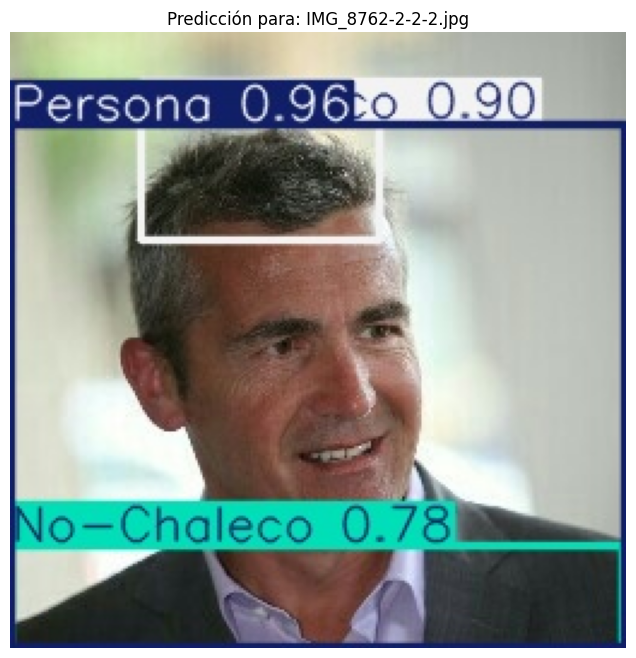


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/Photo BCA 2.jpg: 640x448 1 No-Casco, 1 No-Chaleco, 1 Persona, 61.8ms
Speed: 2.9ms preprocess, 61.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


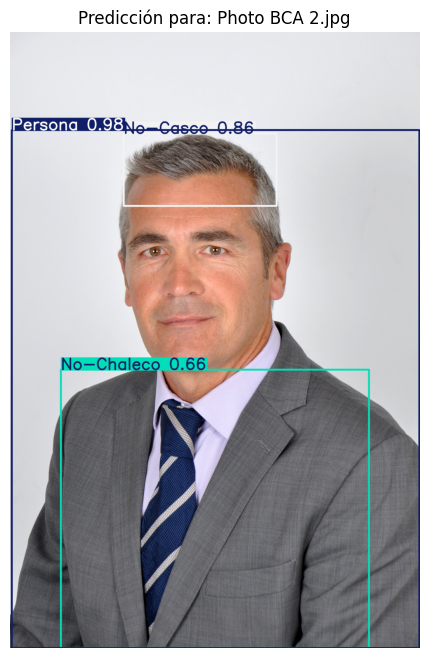


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/IMG_20151020_214137.jpg: 640x480 1 No-Casco, 1 No-Chaleco, 1 Persona, 65.4ms
Speed: 3.3ms preprocess, 65.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


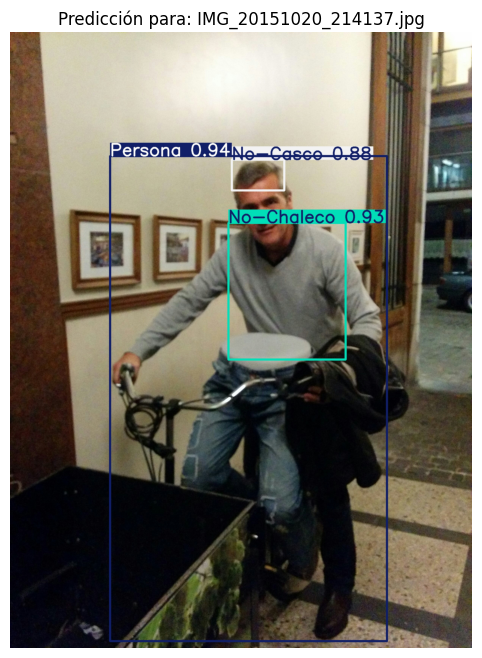


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/helmet_jacket_07012.jpg: 640x640 2 Chalecos, 1 No-Casco, 4 No-Chalecos, 6 Personas, 16.2ms
Speed: 2.4ms preprocess, 16.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


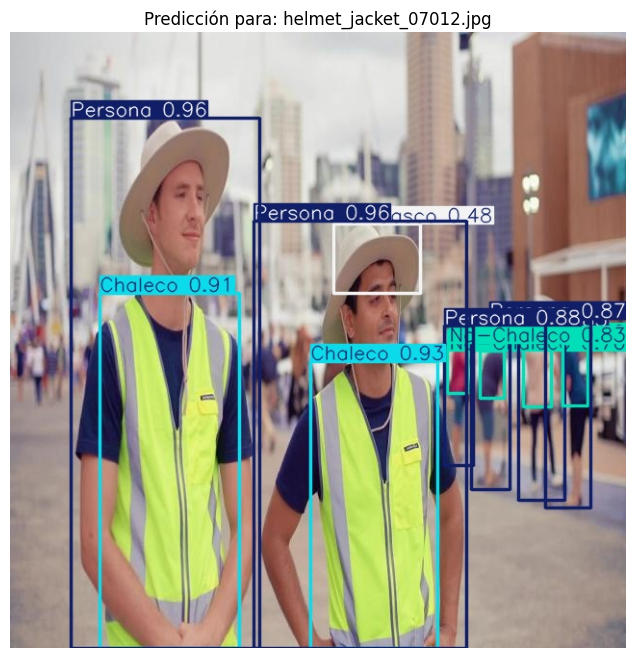


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/helmet_jacket_07041.jpg: 640x640 4 Chalecos, 1 No-Casco, 2 Personas, 14.8ms
Speed: 1.6ms preprocess, 14.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


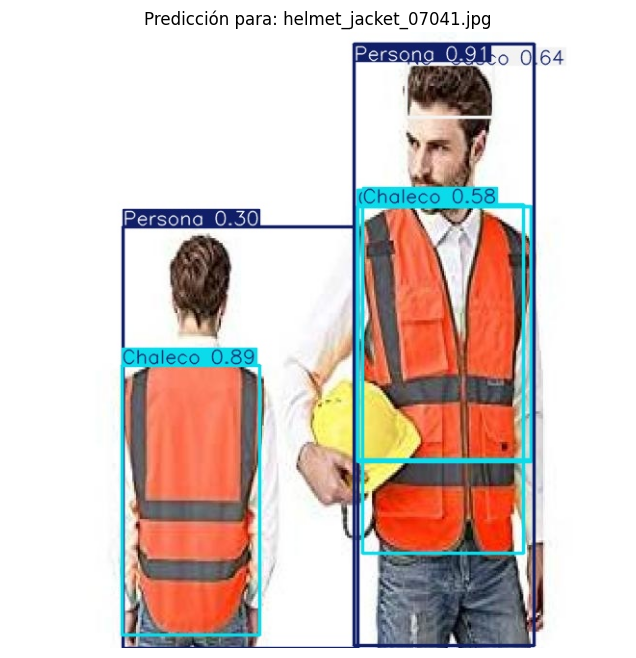


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/helmet_jacket_07057.jpg: 640x640 3 Cascos, 3 Chalecos, 1 No-Chaleco, 3 Personas, 14.5ms
Speed: 1.7ms preprocess, 14.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


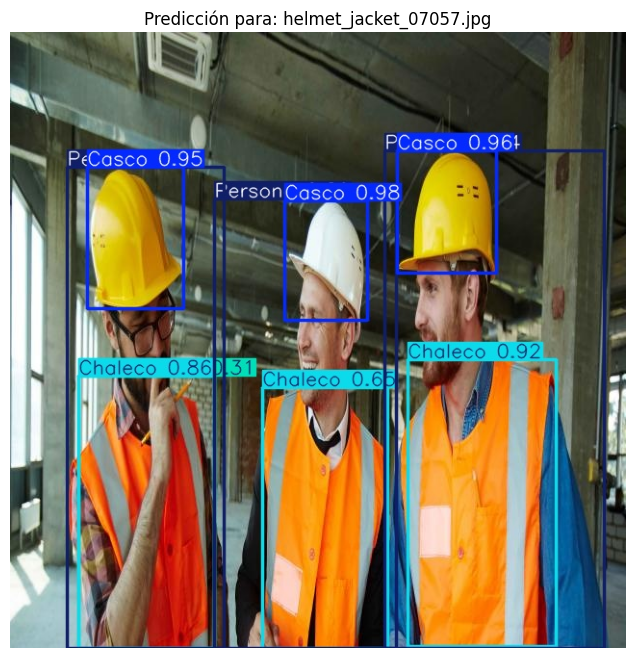


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/helmet_jacket_07052.jpg: 640x640 1 Chaleco, 1 No-Casco, 1 No-Chaleco, 2 Personas, 15.8ms
Speed: 1.5ms preprocess, 15.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


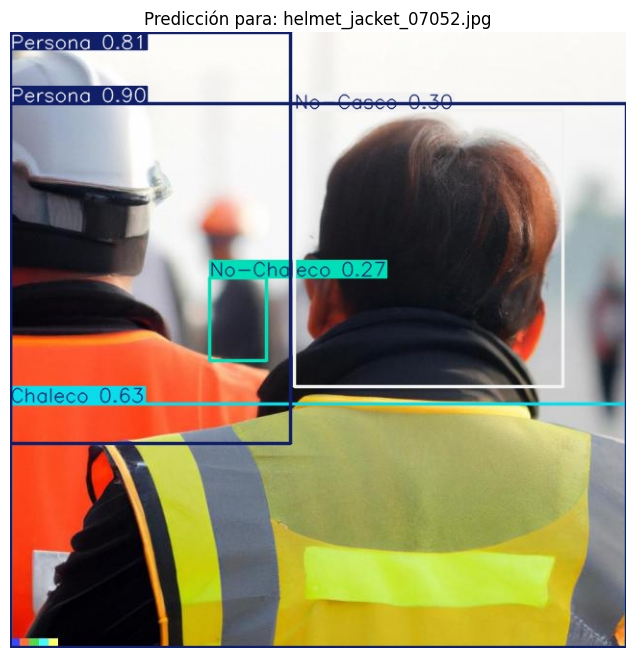


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/helmet_jacket_07073.jpg: 640x640 2 Cascos, 2 Chalecos, 2 Personas, 14.9ms
Speed: 1.7ms preprocess, 14.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


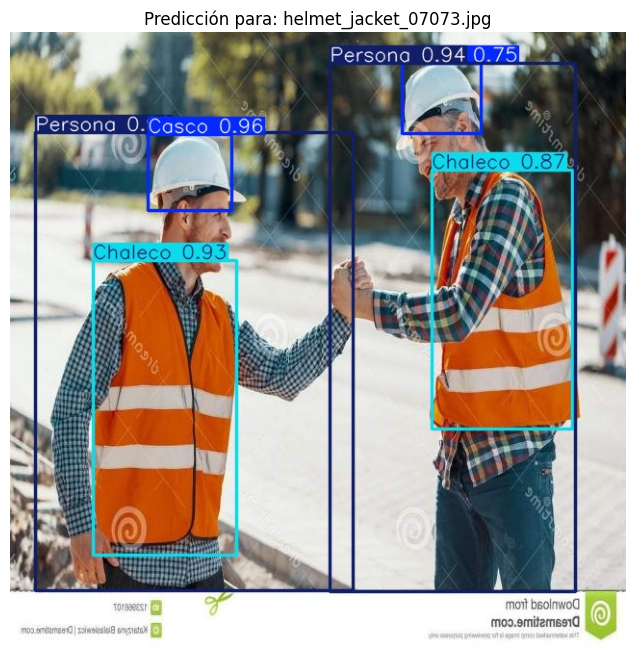


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/helmet_jacket_07121.jpg: 640x640 1 Casco, 1 Chaleco, 1 No-Chaleco, 3 Personas, 18.7ms
Speed: 1.6ms preprocess, 18.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


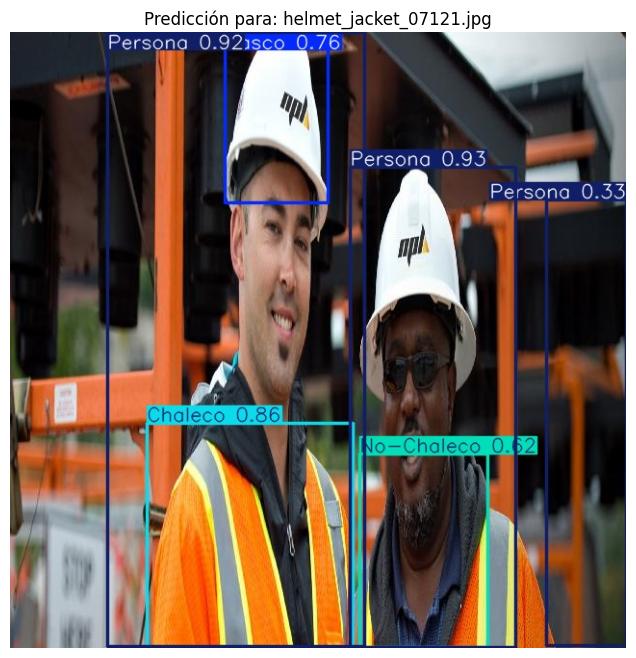


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/hard_hat_workers318.jpg: 640x640 1 Casco, 2 Chalecos, 2 Personas, 14.4ms
Speed: 2.4ms preprocess, 14.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


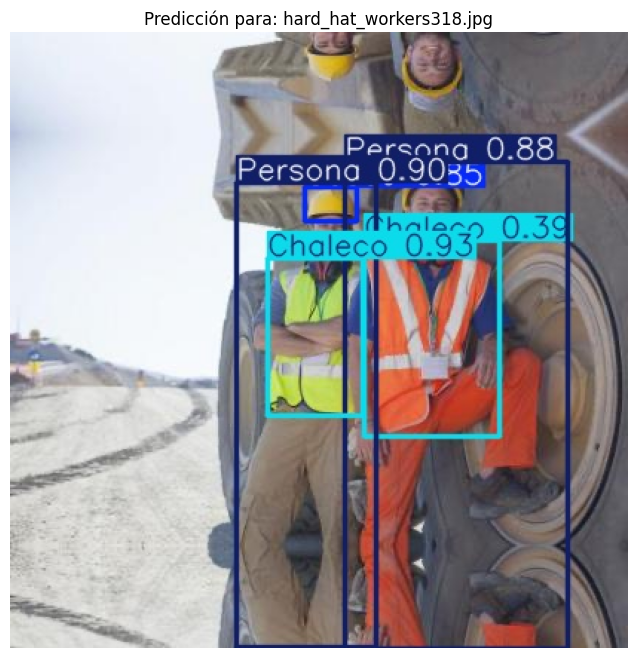


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/WhatsApp Image 2024-12-05 at 17.38.18.jpg: 640x320 2 No-Cascos, 2 No-Chalecos, 3 Personas, 60.4ms
Speed: 1.8ms preprocess, 60.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


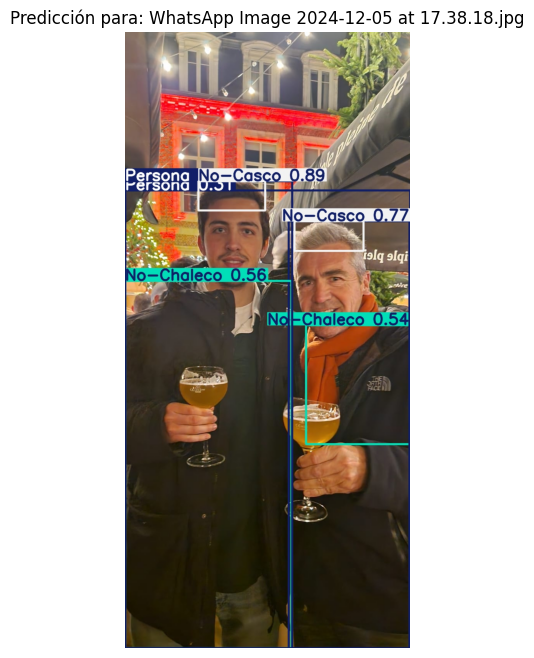


image 1/1 /content/drive/My Drive/TFM DATASET YOLO/test1/Fog image.jpg: 640x320 1 No-Casco, 1 No-Chaleco, 1 Persona, 17.5ms
Speed: 2.9ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)
Results saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions
277 labels saved to /content/drive/My Drive/TFM DATASET YOLO/predictions/predictions/labels


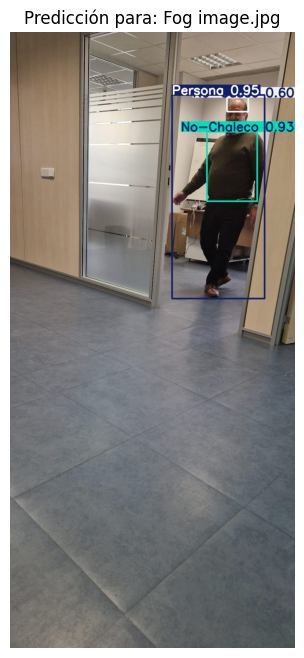

✅ Las predicciones se han guardado en: /content/drive/My Drive/TFM DATASET YOLO/predictions/


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from google.colab import files


import locale
# Correction locale UTF-8
locale.getpreferredencoding = lambda: "UTF-8"

drive.mount('/content/drive')
!ls "/content/drive/My Drive/TFM DATASET YOLO/"
print(os.listdir('/content/drive/My Drive/TFM DATASET YOLO/test1'))

# Directorio para cargar el archivo de pesos
uploaded_weights_dir = './uploaded_weights'
os.makedirs(uploaded_weights_dir, exist_ok=True)

# Subir el archivo de pesos
print("\n=== Cargar el modelo YOLO ===")
uploaded_files = files.upload()

# Detectar el archivo de pesos subido
best_weight_path = None
for file_name in uploaded_files.keys():
    file_path = os.path.join(uploaded_weights_dir, file_name)
    with open(file_path, 'wb') as f:
        f.write(uploaded_files[file_name])
    if "best" in file_name:
        best_weight_path = file_path
    print(f"✅ Archivo {file_name} guardado en: {file_path}")

if not best_weight_path:
    raise FileNotFoundError("❌ No se encontró ningún archivo con 'best' en el nombre entre los archivos subidos.")

# Configurar directorios
test_dir = '/content/drive/My Drive/TFM DATASET YOLO/test1'  # Directorio con imágenes de prueba
predictions_dir = '/content/drive/My Drive/TFM DATASET YOLO/predictions/'  # Directorio para guardar las predicciones

# Crear el directorio de predicciones si no existe
os.makedirs(predictions_dir, exist_ok=True)


# Verificar si el directorio de imágenes de prueba contiene imágenes
image_paths = glob.glob(os.path.join(test_dir, '*.[jp][pn]g')) + glob.glob(os.path.join(test_dir, '*.png'))   # Procesar solo imágenes .jpg
if not image_paths:
    print(f"No se encontraron imágenes en el directorio: {test_dir}")
    raise FileNotFoundError(f"No se encontraron imágenes en el directorio: {test_dir}")
else:
    print(f"{len(image_paths)} imágenes encontradas. Generando predicciones...")

# Cargar el modelo YOLO
print(f"Cargando el modelo desde: {best_weight_path}")
model = YOLO(best_weight_path)

# Generar predicciones y mostrar resultados
for img_path in image_paths:
    # Realizar predicción
    results = model.predict(
        source=img_path,  # Imagen de entrada
        save=True,  # Guardar resultados
        save_txt=True,  # Guardar resultados en formato TXT (opcional)
        conf=0.25,  # Umbral de confianza para las predicciones
        project=predictions_dir,  # Directorio para guardar las predicciones
        name='predictions',  # Subdirectorio donde se organizan las predicciones
        exist_ok=True  # No sobrescribir directorios existentes
    )

    # Mostrar la imagen predicha
    predicted_image_path = os.path.join(predictions_dir, 'predictions', os.path.basename(img_path))
    if os.path.exists(predicted_image_path):
        predicted_image = Image.open(predicted_image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(predicted_image)
        plt.axis('off')  # Ocultar ejes
        plt.title(f"Predicción para: {os.path.basename(img_path)}")
        plt.show()

print(f"Las predicciones se han guardado en: {predictions_dir}")